# Gaussian Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.kernel_ridge import KernelRidge as KR

In [2]:
import warnings
warnings.simplefilter('ignore')

## Process the Datasetes

In [3]:
import pandas as pd
import git

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
datadir = f"{homedir}/data/us/"

df = pd.read_csv(datadir + 'covid/nyt_us_counties.csv')

In [4]:
df['date_processed'] = pd.to_datetime(df['date'].values)
df['date_processed'] = (df['date_processed'] - df['date_processed'].min()) / np.timedelta64(1, 'D')

In [5]:
df.head()

,date,county,state,fips,cases,deaths,date_processed
0,2020-01-21,Snohomish,Washington,53061.0,1,0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0,1.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0,2.0
3,2020-01-24,Cook,Illinois,17031.0,1,0,3.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0,3.0


Fix the missing FIPS codes for some counties

In [6]:
# Manually set the FIPS codes for NYC and Guam as the data does 
# not have those set. 
df.loc[df['county'] == 'New York City', 'fips'] = 25017
df.loc[df['state'] == 'Guam', 'fips'] = 66010

# Remove areas with no FIPS codes.
df = df[df['fips'].isna() == False]

Great! Let's also make a helper function to select data from a region, starting when the pandemic hit to be able to fit models.

In [7]:
# return data ever since first min_cases cases
def select_region(df, fips, min_deaths=-1):
    d = df.loc[df['fips'] == fips]
    deaths = np.where(d['deaths'].values > min_deaths)[0]
    if len(deaths) == 0:
        return []
    start = deaths[0]
    d = d[start:]
    return d

In [8]:
import utils2 as utils
df = utils.get_processed_df()
print(df.head)

<bound method NDFrame.head of               date      county       state     fips  cases  deaths  \
0       2020-01-21   Snohomish  Washington  53061.0      1       0   
1       2020-01-22   Snohomish  Washington  53061.0      1       0   
2       2020-01-23   Snohomish  Washington  53061.0      1       0   
3       2020-01-24        Cook    Illinois  17031.0      1       0   
4       2020-01-24   Snohomish  Washington  53061.0      1       0   
...            ...         ...         ...      ...    ...     ...   
170798  2020-05-23    Sublette     Wyoming  56035.0      3       0   
170799  2020-05-23  Sweetwater     Wyoming  56037.0     25       0   
170800  2020-05-23       Teton     Wyoming  56039.0    100       1   
170801  2020-05-23       Uinta     Wyoming  56041.0     12       0   
170802  2020-05-23    Washakie     Wyoming  56043.0     20       1   

        date_processed  
0                  0.0  
1                  1.0  
2                  2.0  
3                  3.0  
4   

In [9]:
import pymc3 as pm
import arviz as az

## Gaussian Process with Erf prior

In [10]:
import erf_model_small_changes as em

In [11]:
out_fips, all_row_starts = utils.all_output_fips('sample_submission.csv')
print(len(out_fips))

3223


In [14]:
county_fips = 36061
d = select_region(df, county_fips)
if np.max(d['deaths']) == 0:
    result = np.zeroes((num_days, 9))
print(d.tail)

<bound method NDFrame.tail of               date         county     state     fips   cases  deaths  \
416     2020-03-01  New York City  New York  36061.0       1       0   
448     2020-03-02  New York City  New York  36061.0       1       0   
482     2020-03-03  New York City  New York  36061.0       2       0   
518     2020-03-04  New York City  New York  36061.0       2       0   
565     2020-03-05  New York City  New York  36061.0       4       0   
...            ...            ...       ...      ...     ...     ...   
157768  2020-05-19  New York City  New York  36061.0  198710   20376   
160716  2020-05-20  New York City  New York  36061.0  199392   20422   
163668  2020-05-21  New York City  New York  36061.0  200507   20491   
166625  2020-05-22  New York City  New York  36061.0  201298   20569   
169587  2020-05-23  New York City  New York  36061.0  202062   20621   

        date_processed  
416               40.0  
448               41.0  
482               42.0  
518  

In [15]:
import theano.tensor as tt

class Erf(pm.gp.mean.Mean):
    def __init__(self, fit_func, params):
        # Erf.__init__(self)
        self.fit_func = fit_func
        self.params = params

    def __call__(self, X):
        X = X.reshape(1, -1)[0]
        return em.run_model(self.fit_func, self.params, X)

In [36]:

with pm.Model() as gp_covid_model:
    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 15)
    η = pm.HalfCauchy('η', 15)

    fit_func, popt, pcov, X_train, y_train, X_pred = em.fit_erf(df, county_fips)
    print(popt)
    print(y_train)
#     errors = np.sqrt(np.diag(pcov))
#     print(errors)
    # X_pred = X_pred[X_pred >= X_train[0]]

    # Set the Erf prior
    M = Erf(fit_func, popt)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ)

    σ = pm.HalfNormal('σ', 50)

    covid_deaths_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    covid_deaths_gp.marginal_likelihood('covid_deaths', X=X_train.reshape(-1, 1), 
                           y=y_train, noise=σ)

[4.31430972e+00 5.71415816e-02 8.47621305e+01]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     1     5     7    11    25    31    54    75   119   155   230
   330   435   560   825   991  1202  1475  1848  2152  2648  3221  3646
  4857  5631  6441  7249  7981  8734  9448 10096 10857 11566 12109 12283
 12411 13632 14074 14513 14959 15361 15754 16146 16486 16821 17206 17597
 17809 17931 18021 18451 18580 18719 18993 19141 19210 19324 19436 19563
 19736 19815 19904 19972 20071 20214 20298 20376 20422 20491 20569 20621]


In [37]:
# tune = 2000, random_seed=42
if len(popt) == 2:
    with gp_covid_model:
        gp_trace = pm.sample(100, tune=100, cores=2, random_seed=10)
else:
    with gp_covid_model:
        gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:29<00:00, 204.10draws/s]


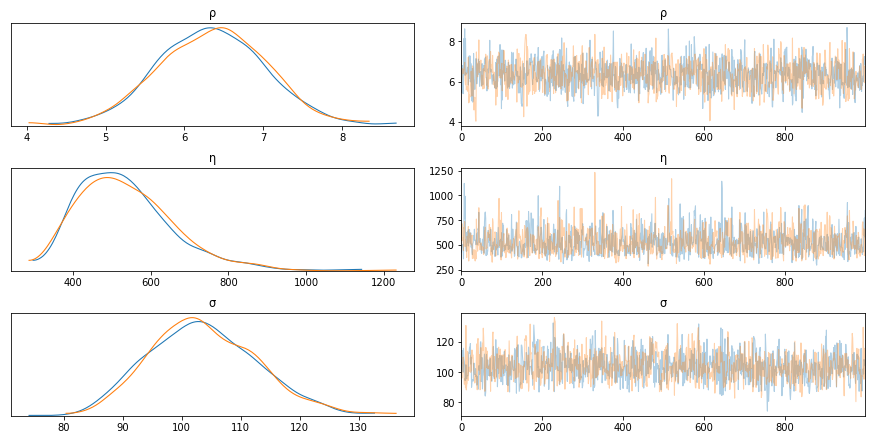

In [38]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [39]:
with gp_covid_model:
    covid_pred = covid_deaths_gp.conditional("covid_pred", X_pred.reshape(-1, 1))
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred], samples=3, random_seed=42)

100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


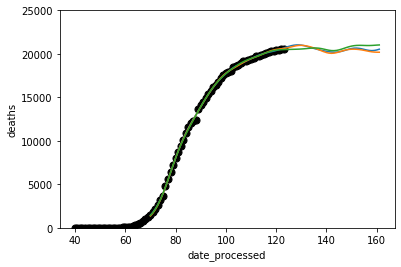

In [40]:
ax = d.plot.scatter(x='date_processed', y='deaths', c='k', s=50)
ax.set_ylim(0, 25000)
for x in gp_covid_samples['covid_pred']:
    ax.plot(X_pred, x)

In [41]:
with gp_covid_model:
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred], samples=100, random_seed=42)

100%|██████████| 100/100 [00:00<00:00, 111.76it/s]


(0, 25000)

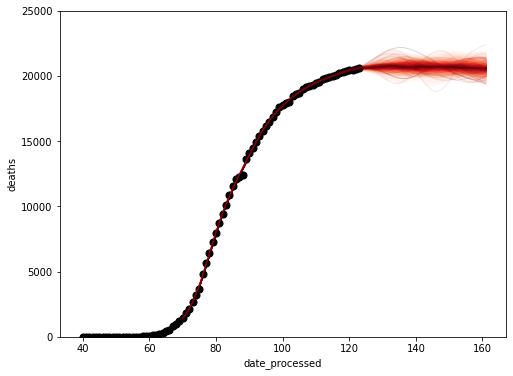

In [42]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_covid_samples['covid_pred'], X_pred)
d.plot.scatter(x='date_processed', y='deaths', c='k', s=50, ax=ax)
ax.set_ylim(0, 25000)

In [43]:
with gp_covid_model:
    covid_pred_noise = covid_deaths_gp.conditional("covid_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_covid_samples = pm.sample_posterior_predictive(gp_trace, vars=[covid_pred_noise], samples=500, random_seed=42)

100%|██████████| 500/500 [00:03<00:00, 127.85it/s]


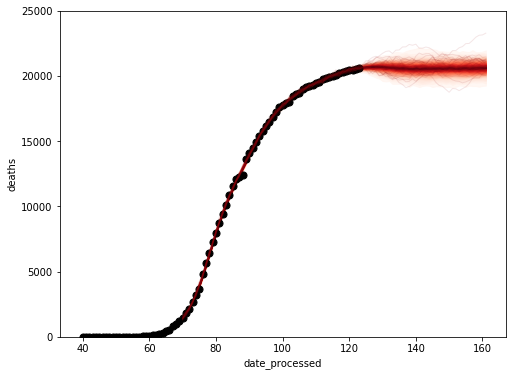

In [44]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_covid_samples['covid_pred_noise'], X_pred)
d.plot.scatter(x='date_processed', y='deaths', c='k', s=50, ax=ax)
ax.set_ylim(0, 25000);

In [45]:
print(np.diff(gp_covid_samples['covid_pred_noise'][1]))
print(np.diff(gp_covid_samples['covid_pred_noise'])[1])
# print(np.percentile(gp_covid_samples['covid_pred_noise'], 90, axis=0))

[ 192.61463412  327.90105014  491.55409964  531.30150682  633.5310972
  807.8703813   939.4513616   808.60222676  686.18083141 1010.17232317
  873.08418641  661.2703459   639.94480779  372.389653    725.24342954
  506.27155655  607.79298487  557.77835595  323.80058089  581.61096988
  420.82010326  688.5444469   158.64244469  738.55748468  317.20561876
  410.82049987  372.73528661  115.38172341  388.11594453  175.55298333
  375.69153905  176.60702746  139.13532387  205.48949238  298.87784564
  -20.01346485  108.04362307   60.31705417  114.41870262  351.77999996
   80.67500715   96.72766127  197.62595369  231.66025259 -102.58106211
  197.72006804   90.66589663  173.03081893  -92.32598193   11.0521476
  152.4198951    61.69705639   29.42720212  170.16992377  -63.56066568
 -315.34978884  103.09505609 -109.99074648  146.51646394  -43.61338725
  -97.65018143  192.81146531   32.75141406   37.81878205  211.63408273
  116.63392161 -179.81211184  137.11876129 -167.81219683  322.04568417
    5.12